In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import datetime
import pandas as pd
import numpy as np
from functools import partial
from dateutil import parser as dtparser

from utils.datafetch import *
from utils.vectorized_funs import *
from utils.datapipe import *
from utils.kerasutil import *
from FintechCapstone import FinCapstone

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from __future__ import print_function


Using TensorFlow backend.


In [5]:
%matplotlib inline

plt.style.use('seaborn-whitegrid')
date_from = '2009-01-01'
date_to = '2017-03-01'
timespan = {
    "short_term": [1, 5]
    ,"medium_term": [40]
    ,"long_term": [90]
}

timespan_ab = {
    "short_term": []
    ,"medium_term": [30]
    ,"long_term": []
}

trial = FinCapstone(ticker_list=["ZHNE","BSFT","AERO","MATR","ITMSF","FIT","TIPT","OLBK","QADA","ATTU","LGF","STX","TPCS","GSAT","ZNGA","GLW","HIMX","YHOO", "NWSA","JAKK","GLUU","AMZN", "AAPL", "EBAY", "GOOG", "DIS", "NFLX", "EA", "TWTR", "FB", "TTWO", "PXLW", "UBI"], ticker_list_samplesize=4, timespan=timespan, timespan_ab=timespan_ab, date_from=date_from)
#trial = FinCapstone(ticker_list_samplesize=200, timespan=timespan, timespan_ab=timespan_ab, date_from=date_from)

#trial.run_initial_dataload()
#trial.feature_engineering(feature_set="triala")

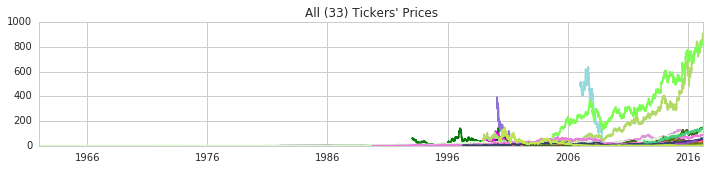

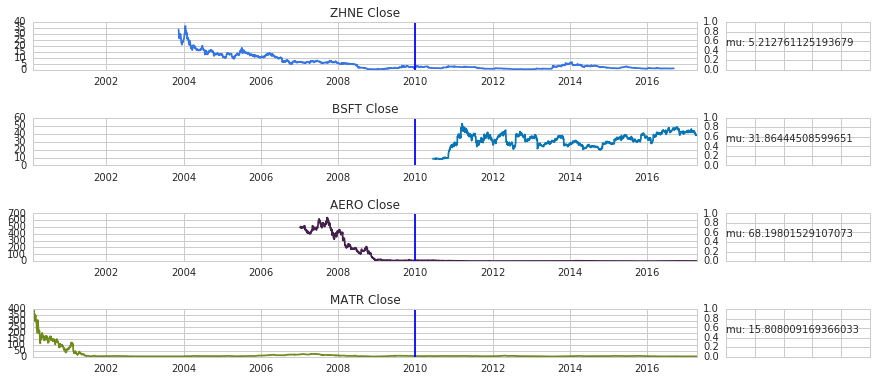

In [4]:
def plot_allprices(ticker_list):
    
    ## Setup our image
    fig = plt.figure(figsize=(15, 3))
    grid = plt.GridSpec(4, 5, hspace=0.2, wspace=0.2)
    
    
    main_ax = fig.add_subplot(grid[:-1, :4])

    main_ax.set_title("All ({}) Tickers' Prices".format(ticker_list.shape[0]))
    for itr_ticker in ticker_list:
        #Load Dataframes with the raw prices
        raw_df = load_raw_frame(itr_ticker, tryfetch=True, dropAdjClose=True)
        raw_df.set_index("Date", inplace=True)
        
        x = raw_df.index.tolist()
        
        #Plot close price
        main_ax.plot(x, raw_df["Close"], '-g', label="Close", c=np.random.rand(3,1))


    plt.show()

def plot_allprices_list(ticker_list):
    
    ## Setup our image
    fig = plt.figure(figsize=(15, 1.5*ticker_list.shape[0]))
    grid = plt.GridSpec(ticker_list.shape[0], 5, hspace=1, wspace=0.2)
    ax = []
    summary = []
    
    for idx_ticker, itr_ticker in enumerate(ticker_list):
        ax.append(fig.add_subplot(grid[idx_ticker, :4], sharex=(None if idx_ticker == 0 else ax[0])))
        summary.append(fig.add_subplot(grid[idx_ticker, 4]))
    
    for idx_ticker, itr_ticker in enumerate(ticker_list):
        #Load Dataframes with the raw prices
        raw_df = load_raw_frame(itr_ticker, tryfetch=True, dropAdjClose=True)
        raw_df.set_index("Date", inplace=True)
        
        x = raw_df.index.tolist()
        
        #Plot close price
        ax[idx_ticker].plot(x, raw_df["Close"], '-g', label="Close", c=np.random.rand(3,1))
        ax[idx_ticker].set_title("{} Close".format(itr_ticker))
        
        ax[idx_ticker].axvline(x='2010-01-01')
        
        summary[idx_ticker].text(0,0.5, 'mu: {}'.format(raw_df["Close"].mean()))
        summary[idx_ticker].tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            left='off',      # ticks along the bottom edge are off
            right='off',         # ticks along the top edge are of
            labelbottom='off') # labels along the bottom edge are off        


    plt.show()

plot_allprices(trial.valid_ticker_list())
plot_allprices_list(trial.valid_ticker_list()[:4])

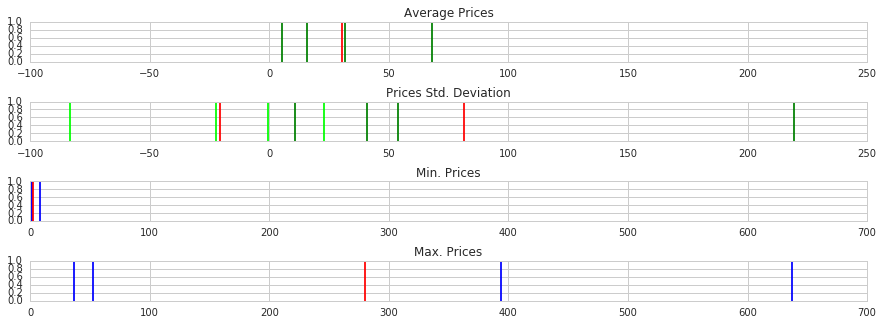

In [5]:
def plot_pricedist(ticker_list):
    _tickers = dict()
    _pnl = None
    
    ## Setup our image
    fig = plt.figure(figsize=(15, 5))
    grid = plt.GridSpec(4, 4, hspace=1, wspace=0.2)
    
    mean_ax = fig.add_subplot(grid[0, :])
    std_ax = fig.add_subplot(grid[1, :], sharex=mean_ax)
    min_ax = fig.add_subplot(grid[2, :])
    max_ax = fig.add_subplot(grid[3, :], sharex=min_ax)
    
    mean_ax.set_title("Average Prices")
    std_ax.set_title("Prices Std. Deviation")
    min_ax.set_title("Min. Prices")
    max_ax.set_title("Max. Prices")

    
    for itr_ticker in ticker_list:
        #Load Dataframes with the raw prices
        raw_df = load_raw_frame(itr_ticker, tryfetch=True, parseDate=True, dropAdjClose=True)
        raw_df.set_index("Date", inplace=True)
        
        mean_ax.axvline(x=raw_df["Close"].mean(), color="green")
        std_ax.axvline(x=raw_df["Close"].mean() + raw_df["Close"].std(), color="green")
        std_ax.axvline(x=raw_df["Close"].mean() - raw_df["Close"].std(), color="lime")
        min_ax.axvline(x=raw_df["Close"].min())
        max_ax.axvline(x=raw_df["Close"].max())
        
        _tickers[itr_ticker] = raw_df.describe()
    
    _pnl = pd.Panel(_tickers)
    
    
    mean_ax.axvline(x=_pnl[:,"mean","Close"].mean(), color="red")
    std_ax.axvline(x=_pnl[:,"mean","Close"].mean() - _pnl[:,"std","Close"].mean(), color="red")
    std_ax.axvline(x=_pnl[:,"mean","Close"].mean() + _pnl[:,"std","Close"].mean(), color="red")
    min_ax.axvline(x=_pnl[:,"min", "Close"].mean(), color="red")
    max_ax.axvline(x=_pnl[:,"max", "Close"].mean(), color="red")


    plt.show()

plot_pricedist(trial.valid_ticker_list()[:4])

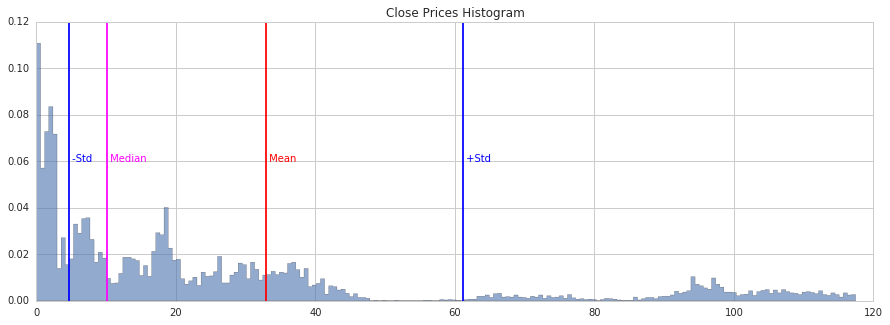

In [9]:
scale = 3
_tickers = dict()
_data = dict()


## Iterate all tickers to read stats and prices
for itr_ticker in trial.valid_ticker_list():
    raw_df = load_raw_frame(itr_ticker, parseDate=True, dropAdjClose=True)
    raw_df.set_index("Date", inplace=True)
    
    ##Store Stats
    _tickers[itr_ticker] = raw_df.describe()
    ##Store Prices and Volume
    _data[itr_ticker] = raw_df.loc[:, ["Close", "Volume"]]


##Convert into DataPanels
_stats = pd.Panel(_tickers)
_pnl = pd.Panel(_data)


mu = _stats[:,"mean","Close"].mean()
std = _stats[:,"std","Close"].mean()
mode = _stats[:,"std","Close"].mode()
median = _stats[:,"std","Close"].median()


#Create Bin range from [-std, +std] with centered mean
bins = np.linspace(max(mu - scale*std, 0), mu + scale*std, 200)

## Setup our image
fig = plt.figure(figsize=(15, 5))
grid = plt.GridSpec(4, 4, hspace=1, wspace=0.2)


#Close Ploting
ax = fig.add_subplot(grid[0:, :])

kwargs = dict(histtype='stepfilled', alpha=0.6, normed=True, bins=bins)

ax.set_title("{} Prices Histogram".format("Close"))
ax.hist(_pnl[:,:,"Close"].dropna().values.flatten(), **kwargs)

#Mark descriptive stats
ax.axvline(mu, color="red")
ax.axvline(mu-std, color="blue")
ax.axvline(mu+std, color="blue")
ax.axvline(median, color="magenta")

#Annotate descriptive stats
ax.text(mu,     (0.5 * ax.get_ylim()[1]), " Mean", color="red")
ax.text(mu-std, (0.5 * ax.get_ylim()[1]), " -Std", color="blue")
ax.text(mu+std, (0.5 * ax.get_ylim()[1]), " +Std", color="blue")
ax.text(median, (0.5 * ax.get_ylim()[1]), " Median", color="magenta")

plt.show()



In [6]:
_dict = dict()

for itr_ticker in trial.valid_ticker_list():    
    itr_df = trial.load_triala_features(itr_ticker, parseDate=True)
    itr_df.set_index("Date", inplace=True)
    _dict[itr_ticker] = itr_df


master_panel = pd.Panel(_dict)
master_panel = master_panel.swapaxes(0,1).swapaxes(2,1)


for itr_ticker in trial.valid_ticker_list():
    master_panel.loc[:,:,itr_ticker].where(~np.isnan(master_panel.loc[:,:,itr_ticker]), 0.0, inplace=True)
    master_panel.loc[:,:,itr_ticker].where(-np.isinf(master_panel.loc[:,:,itr_ticker]), 0.0, inplace=True)

def get_normalizer(col):
    _r = [master_panel.loc[:,col,:].max().max(), master_panel.loc[:,col,:].min().min()]
    _r = np.abs(_r)
    _r = np.max(_r)
    return _r


for itr_col in master_panel.major_axis.tolist():
    master_panel.loc[:,itr_col,:] = master_panel.loc[:,itr_col,:] / get_normalizer(itr_col)
    
master_panel


<class 'pandas.core.panel.Panel'>
Dimensions: 2101 (items) x 28 (major_axis) x 33 (minor_axis)
Items axis: 2009-01-02 00:00:00 to 2017-04-17 00:00:00
Major_axis axis: SMA_5 to OBV
Minor_axis axis: AAPL to ZNGA

In [7]:
np.isnan(master_panel).sum().sum().sum()
np.isinf(master_panel).sum().sum().sum()
master_panel.max().max().max()
master_panel.min().min().min()

-1.0

In [8]:
X_PCA = pd.DataFrame()

for itr_ticker in master_panel.minor_axis.tolist():
    X_PCA = pd.concat([X_PCA, master_panel[:,:,itr_ticker].T], axis=1)

#X_PCA = np.nan_to_num(X_PCA)

#X_PCA = X_PCA.fillna(1e-128)

#X_PCA = X_PCA.values
X_PCA.head()

,SMA_5,SMA_30,SMA_60,SMA_200,BOLL_5_UP,BOLL_5_DOWN,BOLL_30_UP,BOLL_30_DOWN,BOLL_60_UP,BOLL_60_DOWN,...,STOCOSCILATOR_14,STOCOSCILATOR_14_SMA,ADX,ADX_PDI,ADX_NDI,AROONUP_20,AROONDOWN_20,CHAIKIN_MFLOW_21,DAILY_MFLOW_21,OBV
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-02,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-05,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-06,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-07,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-08,0.013255,0.0,0.0,0.0,0.013429,0.012985,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
X_PCA = X_PCA.values

In [41]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def pca_results(pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4))
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	#fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	#components.plot(ax = ax, kind = 'bar');
	#ax.set_ylabel("Feature Weights")
	#ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	#for i, ev in enumerate(pca.explained_variance_ratio_):
	#	ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)



In [42]:
pca = PCA(n_components=2)
X_r = pca.fit(X_PCA).transform(X_PCA)
_results = pca_results(pca)
_results["Explained Variance"].cumsum()

Dimension 1    0.2170
Dimension 2    0.3147
Name: Explained Variance, dtype: float64

In [43]:
pca = PCA(n_components=3)
X_r = pca.fit(X_PCA).transform(X_PCA)
_results = pca_results(pca)
_results["Explained Variance"].cumsum()

Dimension 1    0.2170
Dimension 2    0.3147
Dimension 3    0.3649
Name: Explained Variance, dtype: float64

In [44]:
pca = PCA(n_components=4)
X_r = pca.fit(X_PCA).transform(X_PCA)
_results = pca_results(pca)
_results["Explained Variance"].cumsum()

Dimension 1    0.2170
Dimension 2    0.3147
Dimension 3    0.3649
Dimension 4    0.3911
Name: Explained Variance, dtype: float64

In [46]:
pca = PCA(n_components=5)
X_r = pca.fit(X_PCA).transform(X_PCA)
_results = pca_results(pca)
_results["Explained Variance"].cumsum()

Dimension 1    0.2170
Dimension 2    0.3147
Dimension 3    0.3649
Dimension 4    0.3911
Dimension 5    0.4167
Name: Explained Variance, dtype: float64

In [47]:
pca = PCA(n_components=6)
X_r = pca.fit(X_PCA).transform(X_PCA)
_results = pca_results(pca)
_results["Explained Variance"].cumsum()

Dimension 1    0.2170
Dimension 2    0.3147
Dimension 3    0.3649
Dimension 4    0.3911
Dimension 5    0.4167
Dimension 6    0.4399
Name: Explained Variance, dtype: float64

In [48]:
pca = PCA(n_components=10)
X_r = pca.fit(X_PCA).transform(X_PCA)
_results = pca_results(pca)
_results["Explained Variance"].cumsum()

Dimension 1     0.2170
Dimension 2     0.3147
Dimension 3     0.3649
Dimension 4     0.3911
Dimension 5     0.4167
Dimension 6     0.4399
Dimension 7     0.4615
Dimension 8     0.4813
Dimension 9     0.5002
Dimension 10    0.5177
Name: Explained Variance, dtype: float64

In [49]:
pca = PCA(n_components=15)
X_r = pca.fit(X_PCA).transform(X_PCA)
_results = pca_results(pca)
_results["Explained Variance"].cumsum()

Dimension 1     0.2170
Dimension 2     0.3147
Dimension 3     0.3649
Dimension 4     0.3911
Dimension 5     0.4167
Dimension 6     0.4399
Dimension 7     0.4615
Dimension 8     0.4813
Dimension 9     0.5002
Dimension 10    0.5178
Dimension 11    0.5349
Dimension 12    0.5512
Dimension 13    0.5669
Dimension 14    0.5817
Dimension 15    0.5958
Name: Explained Variance, dtype: float64

In [50]:
pca = PCA(n_components=20)
X_r = pca.fit(X_PCA).transform(X_PCA)
_results = pca_results(pca)
_results["Explained Variance"].cumsum()

Dimension 1     0.2170
Dimension 2     0.3147
Dimension 3     0.3649
Dimension 4     0.3911
Dimension 5     0.4167
Dimension 6     0.4399
Dimension 7     0.4615
Dimension 8     0.4813
Dimension 9     0.5002
Dimension 10    0.5178
Dimension 11    0.5349
Dimension 12    0.5512
Dimension 13    0.5669
Dimension 14    0.5817
Dimension 15    0.5958
Dimension 16    0.6095
Dimension 17    0.6226
Dimension 18    0.6349
Dimension 19    0.6465
Dimension 20    0.6576
Name: Explained Variance, dtype: float64

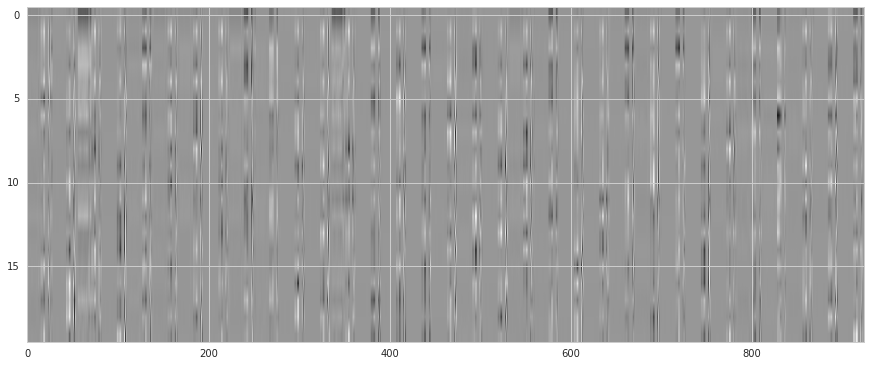

In [61]:
plt.figure(figsize=(15, 6))

plt.imshow(_results.loc[:,_results.columns.tolist()[1:]], aspect="auto")


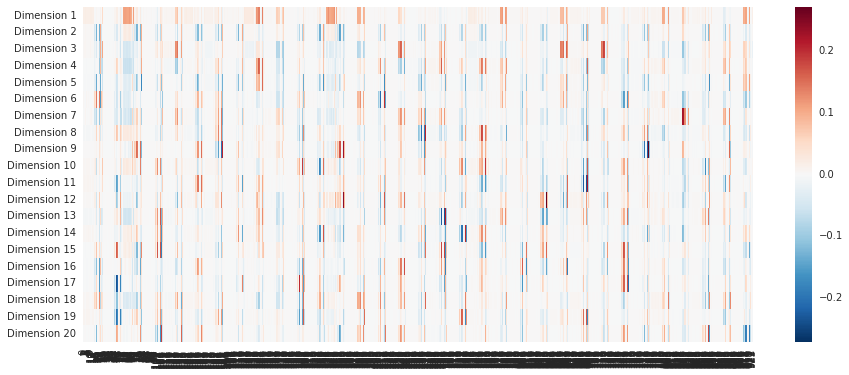

In [60]:
plt.figure(figsize=(15, 6))

sns.heatmap(_results.loc[:,_results.columns.tolist()[1:]])

In [62]:
pca = PCA(n_components=100)
X_r = pca.fit(X_PCA).transform(X_PCA)
_results = pca_results(pca)
_results["Explained Variance"].cumsum()

Dimension 1      0.2170
Dimension 2      0.3147
Dimension 3      0.3649
Dimension 4      0.3911
Dimension 5      0.4167
Dimension 6      0.4399
Dimension 7      0.4615
Dimension 8      0.4813
Dimension 9      0.5002
Dimension 10     0.5178
Dimension 11     0.5349
Dimension 12     0.5512
Dimension 13     0.5669
Dimension 14     0.5817
Dimension 15     0.5958
Dimension 16     0.6095
Dimension 17     0.6226
Dimension 18     0.6349
Dimension 19     0.6465
Dimension 20     0.6576
Dimension 21     0.6684
Dimension 22     0.6790
Dimension 23     0.6890
Dimension 24     0.6982
Dimension 25     0.7071
Dimension 26     0.7158
Dimension 27     0.7242
Dimension 28     0.7321
Dimension 29     0.7398
Dimension 30     0.7472
                  ...  
Dimension 71     0.9085
Dimension 72     0.9108
Dimension 73     0.9131
Dimension 74     0.9153
Dimension 75     0.9175
Dimension 76     0.9196
Dimension 77     0.9217
Dimension 78     0.9237
Dimension 79     0.9257
Dimension 80     0.9277
Dimension 81    

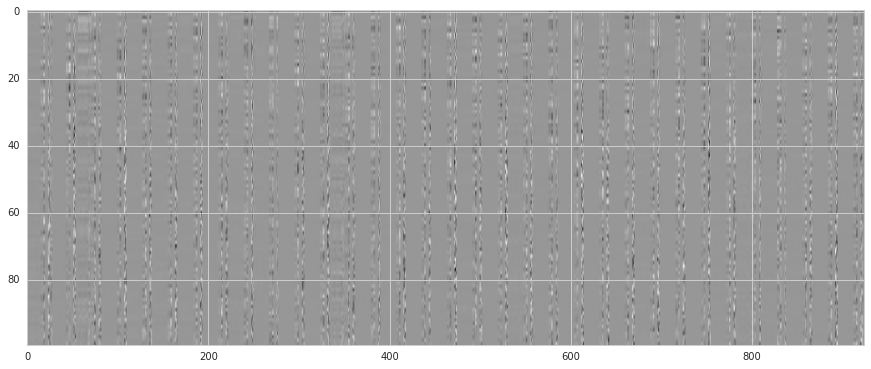

In [63]:
plt.figure(figsize=(15, 6))

plt.imshow(_results.loc[:,_results.columns.tolist()[1:]], aspect="auto")


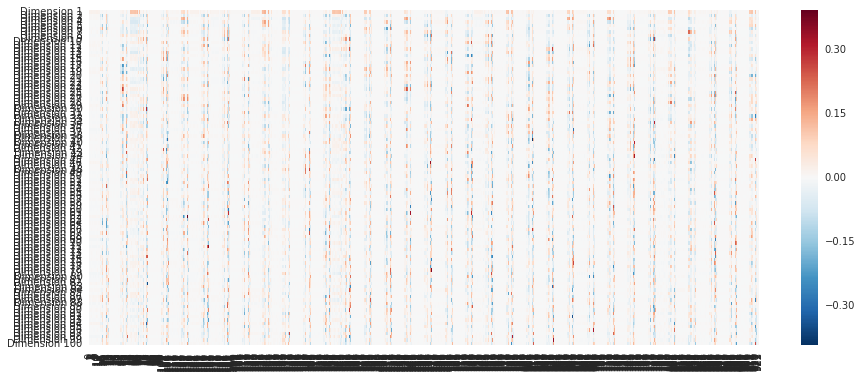

In [64]:
plt.figure(figsize=(15, 6))

sns.heatmap(_results.loc[:,_results.columns.tolist()[1:]])

In [71]:
pca = PCA(n_components=400)
X_r = pca.fit(X_PCA).transform(X_PCA)
_results = pca_results(pca)
_results["Explained Variance"].cumsum()

Dimension 1      0.2170
Dimension 2      0.3147
Dimension 3      0.3649
Dimension 4      0.3911
Dimension 5      0.4167
Dimension 6      0.4399
Dimension 7      0.4615
Dimension 8      0.4813
Dimension 9      0.5002
Dimension 10     0.5178
Dimension 11     0.5349
Dimension 12     0.5512
Dimension 13     0.5669
Dimension 14     0.5817
Dimension 15     0.5958
Dimension 16     0.6095
Dimension 17     0.6226
Dimension 18     0.6349
Dimension 19     0.6465
Dimension 20     0.6576
Dimension 21     0.6684
Dimension 22     0.6790
Dimension 23     0.6890
Dimension 24     0.6982
Dimension 25     0.7071
Dimension 26     0.7158
Dimension 27     0.7242
Dimension 28     0.7321
Dimension 29     0.7398
Dimension 30     0.7472
                  ...  
Dimension 371    0.9993
Dimension 372    0.9993
Dimension 373    0.9993
Dimension 374    0.9993
Dimension 375    0.9993
Dimension 376    0.9993
Dimension 377    0.9993
Dimension 378    0.9993
Dimension 379    0.9993
Dimension 380    0.9993
Dimension 381   

In [82]:
a = _results["Explained Variance"].cumsum()[200] 
b = _results["Explained Variance"].cumsum()[399]

In [83]:
a

0.99849999999999839

In [84]:
b

0.9992999999999983

In [136]:
pca = PCA(n_components=462)
X_r = pca.fit(X_PCA).transform(X_PCA)
_results = pca_results(pca)
_results["Explained Variance"].cumsum()

Dimension 1      0.2170
Dimension 2      0.3147
Dimension 3      0.3649
Dimension 4      0.3911
Dimension 5      0.4167
Dimension 6      0.4399
Dimension 7      0.4615
Dimension 8      0.4813
Dimension 9      0.5002
Dimension 10     0.5178
Dimension 11     0.5349
Dimension 12     0.5512
Dimension 13     0.5669
Dimension 14     0.5817
Dimension 15     0.5958
Dimension 16     0.6095
Dimension 17     0.6226
Dimension 18     0.6349
Dimension 19     0.6465
Dimension 20     0.6576
Dimension 21     0.6684
Dimension 22     0.6790
Dimension 23     0.6890
Dimension 24     0.6982
Dimension 25     0.7071
Dimension 26     0.7158
Dimension 27     0.7242
Dimension 28     0.7321
Dimension 29     0.7398
Dimension 30     0.7472
                  ...  
Dimension 433    0.9993
Dimension 434    0.9993
Dimension 435    0.9993
Dimension 436    0.9993
Dimension 437    0.9993
Dimension 438    0.9993
Dimension 439    0.9993
Dimension 440    0.9993
Dimension 441    0.9993
Dimension 442    0.9993
Dimension 443   

In [137]:
print("{:.{prec}f}".format(_results["Explained Variance"].cumsum()[300], prec=10))
print("{:.{prec}f}".format(_results["Explained Variance"].cumsum()[400], prec=10))

0.9993000000
0.9993000000


In [138]:
_results["Explained Variance"].cumsum()[300] == _results["Explained Variance"].cumsum()[207]

False

In [139]:
np.argmin(_results["Explained Variance"].cumsum() - _results["Explained Variance"].cumsum().shift(1))

'Dimension 210'

In [142]:
pca = PCA(n_components=210)
X_r = pca.fit(X_PCA).transform(X_PCA)
_results = pca_results(pca)
_results["Explained Variance"].cumsum()

Dimension 1      0.2170
Dimension 2      0.3147
Dimension 3      0.3649
Dimension 4      0.3911
Dimension 5      0.4167
Dimension 6      0.4399
Dimension 7      0.4615
Dimension 8      0.4813
Dimension 9      0.5002
Dimension 10     0.5178
Dimension 11     0.5349
Dimension 12     0.5512
Dimension 13     0.5669
Dimension 14     0.5817
Dimension 15     0.5958
Dimension 16     0.6095
Dimension 17     0.6226
Dimension 18     0.6349
Dimension 19     0.6465
Dimension 20     0.6576
Dimension 21     0.6684
Dimension 22     0.6790
Dimension 23     0.6890
Dimension 24     0.6982
Dimension 25     0.7071
Dimension 26     0.7158
Dimension 27     0.7242
Dimension 28     0.7321
Dimension 29     0.7398
Dimension 30     0.7472
                  ...  
Dimension 181    0.9965
Dimension 182    0.9966
Dimension 183    0.9967
Dimension 184    0.9968
Dimension 185    0.9969
Dimension 186    0.9970
Dimension 187    0.9971
Dimension 188    0.9972
Dimension 189    0.9973
Dimension 190    0.9974
Dimension 191   